# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. Using this network, we will be generated new digits!

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

## Generator network

Here we'll build the generator network. We will use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

#### Leaky ReLU
Typically, a parameter `alpha` sets the magnitude of the output for negative values. So, the output for negative input (`x`) values is `alpha*x`, and the output for positive `x` is `x`:
$$
f(x) = max(\alpha * x, x)
$$
For implementing the leaky relu, you could use the following resource https://keras.io/layers/advanced-activations/

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of the usual 0 and 1 range. 

## Discriminator

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.

## Build network

Now we're are going to build the generator and discrimator networks.

We'll create the generator, `generator(input_z, input_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for real data and one for fake data. Since we want the weights to be the same for both real and fake data, we need to reuse the variables. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

In [1]:
# TODO: ALL Keras imports go here.

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from tqdm import tqdm
from __future__ import print_function, division
import matplotlib.pyplot as plt
import sys
import numpy as np

import keras
from keras import optimizers,models
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, UpSampling2D,MaxPooling2D,Conv2DTranspose
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers 
from keras.optimizers import Adam

from keras import backend as K 
# TODO Depending on the ordering of your kernels, and batches you might need to change this!
K.set_image_dim_ordering('th')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load MNIST data
def load_data(path='mnist.npz'):
    """Loads the MNIST dataset.
    # Arguments
        path: path where to cache the dataset locally
            (relative to ~/.keras/datasets).
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = "mnist.npz"
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

In [7]:
(X_train, y_train), (X_test, y_test) = load_data()

In [9]:
X_train.shape


(60000, 28, 28)

In [10]:
latent_dim = 28

In [46]:
# define vars
#g_input_shape = 100 
d_input_shape = (28, 28) 
hidden_1_num_units = 500 
hidden_2_num_units = 500 
g_output_num_units = 784 
d_output_num_units = 1 
#img_shape = (channels, img_rows, img_cols)
epochs = 25 
batch_size = 128

In [32]:
# Generator
def build_generator(latent_dim):
    # TODO. Make sure to use a tanh activation at the last layer and compile the model before returning it
    # For upsampling the image, you could use UpSampling2D function from Keras library. 
    # Use adam optimizer with: adam = Adam(0.0002, 0.5)
    generator_input = Input(shape=(latent_dim,))
    x = Dense(14*14*14)(generator_input)
    x = LeakyReLU()(x)
    x = Reshape((14,14,14))(x)
    
    x = Conv2D(256,5,padding= 'same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256,4,strides=2,padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256,5,padding ='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(256,5,padding ='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(channels,7, activation ='tanh',padding ='same')(x)

    
    #adam = Adam(0.0002,0.5)
    generator = Model(generator_input,x)
   # generator = g_model.compile(optimizer='adam', loss = 'binary_crossentropy')
    
    return generator

In [33]:
g = build_generator(28)

In [34]:
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2744)              79576     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 2744)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 14, 14)       89856     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256, 14, 14)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 256, 28, 28)       1048832   
__________

In [35]:
adam = Adam(0.0002,0.5)

In [36]:
g.compile(optimizer = adam,loss = 'binary_crossentropy')

In [37]:
# Discriminator
def build_discriminator(img_shape):
    # TODO. Make sure to use a sigmoid at the last layer and compile the model before returning it
    # Use adam optimizer with adam = Adam(0.0002, 0.5)
    discriminator_input = Input(shape = img_shape)
    x = Conv2D(128,3)(discriminator_input)
    x = LeakyReLU()(x)
    x = Conv2D(128,4,strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(128,4,strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(128,4,strides=2)(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    
    x = Dropout(0.4)(x)
    
    x = Dense(1,activation = 'sigmoid')(x)
    
    discriminator = Model(discriminator_input,x)
    #discriminator = d_model.compile(optimizer = Adam(0.0002,0.5), loss = 'binary_crossentropy')
    return discriminator


In [38]:
d = build_discriminator((1,28,28))
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 26, 26)       1280      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 128, 26, 26)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 12, 12)       262272    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 128, 12, 12)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 5, 5)         262272    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 128, 5, 5)         0         
__________

In [39]:
d.compile(optimizer=adam,loss ='binary_crossentropy')

In [54]:
##################### TODO #####################
# Now that we've built the disriminator and generator, lets combine the two for the full end to end system.
# This is where we are calculating D(G(z))!
# We will set up a Model object to train the generator to fool the discriminator. We need to turn of
# weight updates for the discriminator, create an Input object for the generator with the right
# dimension, run that through the generator, and run the output of the generator through the discriminator. 
# You should compile this new Model object.
def build_gan(discriminator, generator, latent_dim):
    adam = Adam(0.0002, 0.5)
    discriminator.trainable = False
    gan_input = Input(shape= (latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input,gan_output)
    return gan

In [55]:
# Parameters for our mnist dataset. 
img_rows = 28
img_cols = 28
channels = 1
# Feel free to change the order of channels, rows, and cols if you go ahead with a different order 
# in your discriminator and generator. 
img_shape = (channels, img_rows, img_cols)
latent_dim = 100

In [56]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

In [68]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(optimizer = adam, loss = 'binary_crossentropy')
# Build and compile the generator
generator = build_generator(latent_dim)
generator.compile(optimizer=adam, loss='binary_crossentropy')
# Build and compile the combined network
gan = build_gan(discriminator, generator, latent_dim)
gan.compile(optimizer = adam, loss = 'binary_crossentropy')

In [69]:
epochs = 10
batch_size = 128
save_interval = 50

# Load MNIST data and rescale -1 to 1
(X_train, y_train), (X_test, y_test) = load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

In [59]:
X_train.shape

(60000, 1, 28, 28)

In [60]:
batchCount = X_train.shape[0] / batch_size
batchCount

468.75

In [61]:
random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))

In [62]:
random_latent_vectors.shape

(128, 100)

In [75]:
random_latent_vectors[0]

array([ 0.35256824, -0.8256345 ,  0.80591294, -0.14365716, -0.1241578 ,
        1.78313082, -0.40178333,  0.12481458, -0.50263848,  0.30426837,
       -1.98493761, -0.1028966 ,  0.24530352,  1.05857502, -2.35940976,
       -0.62380173,  1.25882615,  0.16926383, -1.41755525, -1.62303174,
        0.4780204 ,  0.42543101,  0.45394118, -0.63466719,  0.4844463 ,
        2.31807288, -0.14916626, -0.91218193,  1.31920084,  0.56594239,
       -1.59232025, -1.5893838 ,  1.00356555,  0.91821002,  0.19544663,
        1.27119088, -0.03102151, -1.4280335 ,  0.3044777 , -2.12082749,
        0.2721447 , -0.52909584, -0.09530757, -0.25557435, -0.67140881,
        0.20685753, -0.29361302, -1.42384248,  1.33433236, -2.46254361,
        1.21358268,  0.5026833 , -2.48224052,  0.37810564,  1.14589371,
        1.2056658 ,  1.66135076, -0.71449268,  2.16354692,  0.2684169 ,
        0.3654909 , -0.58991298, -0.63760568, -0.77217658,  1.03462277,
       -1.25571053, -0.16100869, -0.81523909,  1.13941533, -0.70

In [63]:
generatedImages = generator.predict(random_latent_vectors)

In [64]:
generatedImages.shape

(128, 1, 28, 28)

In [76]:
generatedImages[0]

array([[[-9.99493301e-01, -9.99964833e-01, -9.99999344e-01,
         -9.99999821e-01, -9.99999404e-01, -9.99999702e-01,
         -9.99999881e-01, -9.99999881e-01, -9.99999821e-01,
         -9.99999046e-01, -9.99993563e-01, -9.99988317e-01,
         -9.99986529e-01, -9.99957025e-01, -9.99875367e-01,
         -9.99849916e-01, -9.99860525e-01, -9.99836028e-01,
         -9.99812305e-01, -9.99719620e-01, -9.99773383e-01,
         -9.99902248e-01, -9.99978542e-01, -9.99994576e-01,
         -9.99995589e-01, -9.99992251e-01, -9.98874426e-01,
         -7.81320453e-01],
        [-9.99442935e-01, -9.99998689e-01, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -9.99999940e-01,
         -9.99999821e-01, -9.99999702e-01, -9.99999523e-01,
         -9.99998927e-01, -9.99997377e-01, -9.99994576e-01,
         -9.9

In [65]:
start = 0
stop = 128
imageBatch = X_train[start:stop]

In [66]:
imageBatch.shape

(128, 1, 28, 28)

In [70]:
# Build and compile the discriminator
#discriminator = build_discriminator(img_shape)
#discriminator.compile(optimizer = adam, loss = 'binary_crossentropy')
# Build and compile the generator
#generator = build_generator(latent_dim)
#generator.compile(opimizer=adam, loss='binary_crossentropy')
# Build and compile the combined network
#gan = build_gan(discriminator, generator, latent_dim)

epochs = 10
batch_size = 128
save_interval = 50

# Load MNIST data and rescale -1 to 1
(X_train, y_train), (X_test, y_test) = load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

batchCount = X_train.shape[0] / batch_size
start = 0
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(int(batchCount))):
        
        # Get a random sample from real images, and from random noise
        stop = start + batch_size
        random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
        imageBatch = X_train[start:stop]
        

        # Generate fake MNIST images, from noise
        generatedImages = generator.predict(random_latent_vectors)
        
        # Lets train the discriminator first. 
        # We will concatenate the real images and fake images into a variable X
        X = np.concatenate([generatedImages, imageBatch])

        # Create the labels for fake and real data, composed of 0s and 1s
        yDis = np.concatenate([np.ones((batch_size,1)),np.zeros((batch_size,1))])
        yDis +=0.5*np.random.random(yDis.shape)

        # Train discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, yDis)

        # Now lets train the generator
        # Generate batch_size sized random noise 
        random_latent_vectors = np.random.normal(size = (batch_size,latent_dim))
        
        # Generate the labels for the generator
        yGen = np.zeros((batch_size,1))
        discriminator.trainable = False
        a_loss = gan.train_on_batch(random_latent_vectors, yGen)
                                    
        start += batch_size
        if start > len(X_train) -batch_size:
           start = 0
        if batchCount%save_interval == 0:
            gan.save_weights('gan_pr.h5')
        
    if e == 1 or e % 5 == 0:
        plotGeneratedImages(e)

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [05:46<00:00,  1.35it/s]


## Results
Please embed some of the images you have generated and turn them in with your notebook!

In [71]:
from IPython.display import Image


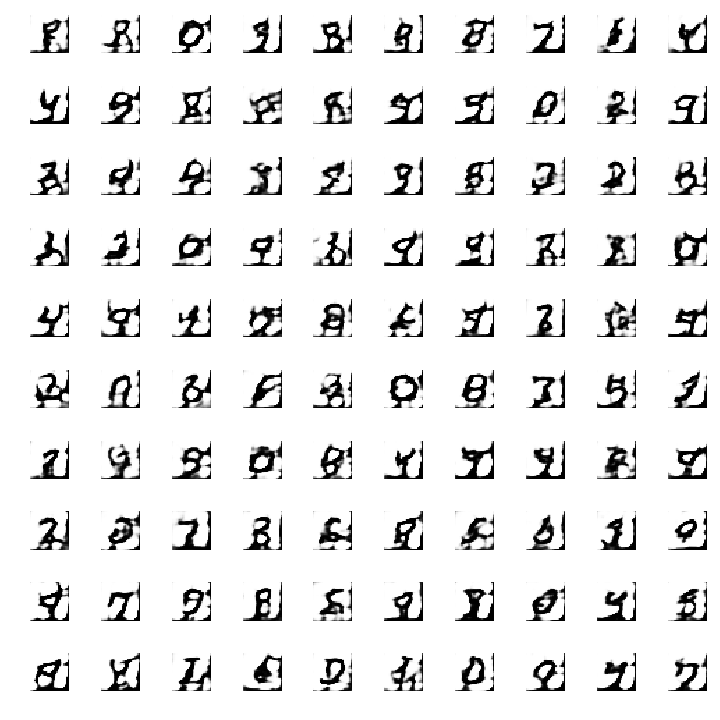

In [72]:
Image("images/dcgan_generated_image_epoch_1.png")

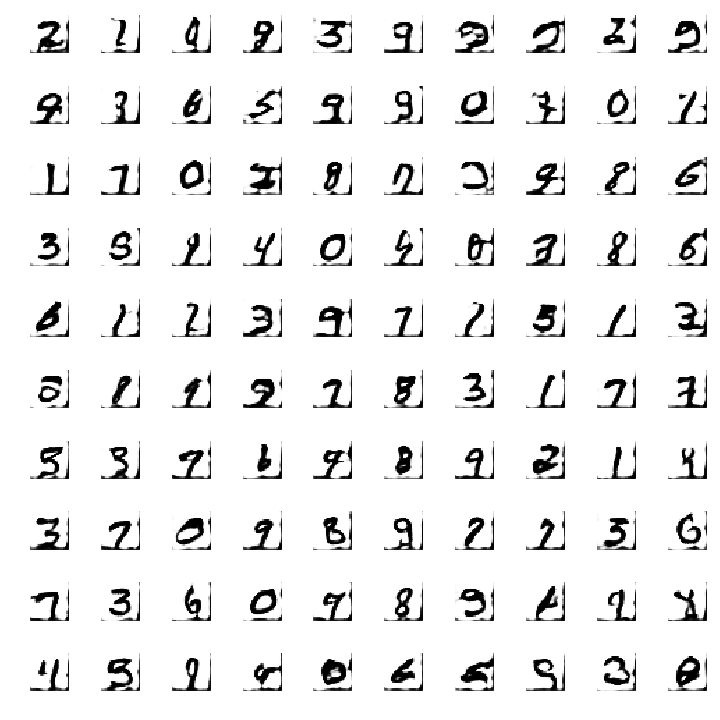

In [73]:
Image("images/dcgan_generated_image_epoch_5.png")

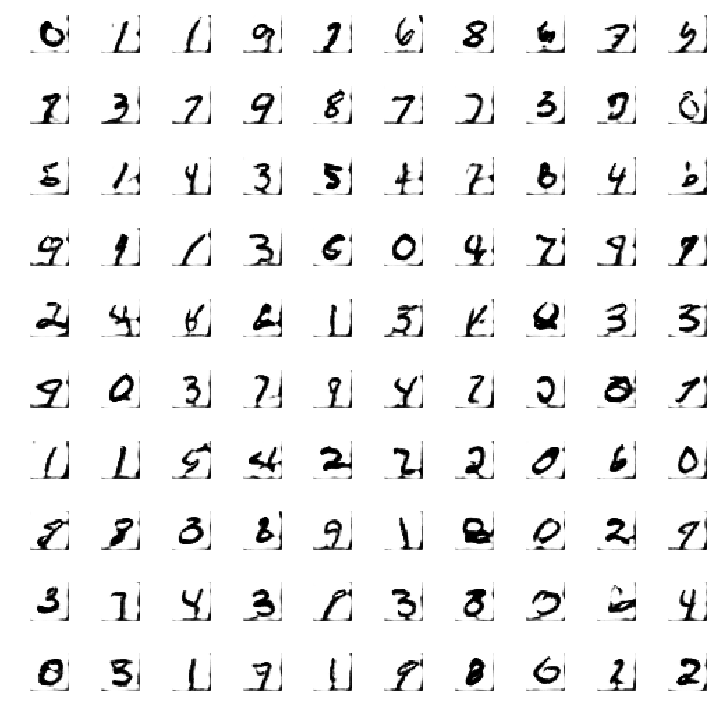

In [74]:
Image("images/dcgan_generated_image_epoch_10.png")